In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from thefuzz import fuzz, process
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizerFast, RobertaModel, RobertaForMaskedLM
from transformers import AlbertTokenizerFast, AlbertForMaskedLM, AlbertModel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


device = 'mps' if torch.backends.mps.is_available() else 'cpu' # Can be changed to 'cuda' for Windows systems with NVIDIA GPUs or hosted notebook, CPU as fallback

# from google.colab import drive
# drive.mount('/content/drive')

/Users/atherv/miniforge3/envs/lifting/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [239]:
huge_data = pd.read_csv('data/600k+ dataset/programs_detailed.csv')

## Data Cleaning

In [240]:
# Convert date columns to Timestamp objects
huge_data['created'] = pd.to_datetime(huge_data['created'])
huge_data['last_edit'] = pd.to_datetime(huge_data['last_edit'])

# Convert level and goal columns from strings to lists
huge_data['level'] = huge_data['level'].apply(eval)
huge_data['goal'] = huge_data['goal'].apply(eval)

In [241]:
# Drop all rows where there is no description, there are only 4 programs without one so this just makes it easier to work with.
# There is also one program that has NA values for nearly all important fields, it's not useful for analysis so we'll drop it.
# One workout just have last_edit column missing, just imputing it with the created column.

# come back to this, could also just fill NA with 'unknown'
huge_data = (huge_data
             .dropna(axis=0, subset=['description', 'equipment'])
             .fillna(value={'last_edit': huge_data['created']})
             .reset_index().drop(columns=['index']))

In [242]:
# Convert all string/object columns in huge_data to lowercase
# Also choosing to not lower the description column, as sentiment information is lost when removing the case
str_cols = huge_data.select_dtypes(include='object').columns.drop(['level', 'goal', 'description'])
huge_data[str_cols] = huge_data[str_cols].apply(lambda x: x.str.lower())

for col in ['level', 'goal']:
    huge_data[col] = huge_data[col].apply(lambda lst: [s.lower() for s in lst])


In [243]:
exercise_sign = (
    huge_data[['exercise_name', 'reps']]
    .dropna(subset=['reps'])
    .query('reps != 0')
    .drop_duplicates(subset=['exercise_name'])
    .assign(sign=lambda d: np.sign(d['reps']))
    .set_index('exercise_name')['sign']
    .to_dict()
)

# Get unique exercise names
raw_exercises = huge_data['exercise_name'].dropna().unique()

# No cleaning – use raw names directly
exercise_to_raw = { ex: ex for ex in raw_exercises }
exercise_list = list(exercise_to_raw.keys())

threshold = 85
exercise_groups = {}

for ex in exercise_list:
    matches = process.extract(
        ex,
        exercise_list,
        scorer=fuzz.token_sort_ratio,
        limit=None
    )
    similar = [m[0] for m in matches if m[1] >= threshold]

    if similar:
        base = min(similar, key=len)
        base_raw = exercise_to_raw[base]

        if base_raw not in exercise_groups:
            exercise_groups[base_raw] = []
        variants = [exercise_to_raw[v] for v in similar]
        exercise_groups[base_raw].extend(variants)
        exercise_groups[base_raw] = list(set(exercise_groups[base_raw]))

grouped_rows = []
for base, variants in exercise_groups.items():
    # Collect signs for this group
    signs = [exercise_sign.get(v, 1) for v in variants]
    majority_sign = 1 if sum(signs) >= 0 else -1  # if there's a tie, just make it positive

    mask = huge_data['exercise_name'].isin(variants)
    huge_data.loc[mask, 'reps'] = huge_data.loc[mask, 'reps'].abs() * majority_sign

    grouped_rows.append({
        'grouped_exercise': base,
        'all_exercises': variants,
        'count': len(variants)
    })

grouped = pd.DataFrame(grouped_rows).sort_values('grouped_exercise').reset_index(drop=True)

In [244]:
# Map grouped exercise names back to the original dataframe
grouped_filtered = grouped[grouped['count'] > 1]

# Create a mapping from each variant to its grouped exercise name
variant_to_grouped = {}
for _, row in grouped_filtered.iterrows():
    base = row['grouped_exercise']
    for variant in row['all_exercises']:
        variant_to_grouped[variant] = base

# Apply the mapping in place to the exercise_name column
huge_data['exercise_name'] = huge_data['exercise_name'].map(variant_to_grouped).fillna(huge_data['exercise_name'])

There are some exercises that have messed up rep counts, for example in the workout program 'filling out the hoodie',

There are multiple exercises that have extraordinarily large rep counts. For example, we can look at the front squat (barbell) exercise:

In [245]:
huge_data[(huge_data['title'] == 'filling out the hoodie') & (huge_data['exercise_name'] == 'front squat (barbell)')].head(8)

,title,description,level,goal,equipment,program_length,time_per_workout,week,day,number_of_exercises,exercise_name,sets,reps,intensity,created,last_edit
292319,filling out the hoodie,The build strength and size,[advanced],[muscle & sculpting],full gym,8.0,90.0,1.0,2.0,5.0,front squat (barbell),3.0,9.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292338,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,1.0,5.0,5.0,front squat (barbell),6.0,12.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292349,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,2.0,5.0,front squat (barbell),3.0,12.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292368,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,5.0,5.0,front squat (barbell),6.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292379,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,2.0,5.0,front squat (barbell),3.0,86400.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292398,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,5.0,5.0,front squat (barbell),6.0,1800.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292409,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,2.0,5.0,front squat (barbell),3.0,600.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292428,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,5.0,5.0,front squat (barbell),6.0,60.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00


Looking at the 'reps' column, we see that some exercises have rep counts for over 600, and one even being 86400! 

This obviously is corrupted data, and we can assume that it had something to do with the workout time the user inputted, as the large numbers are all factors of 60. There are 60 seconds in a minute, and seconds is the unit for the time based workouts. However, these exercises are not time-based, so it's a mystery to how this happened. 

For our case, we will reset out any rep sizes that are greater than 35 to the last known normal rep count for that program and exercise combo. If one cannot be found, we set the rep count to just be 10.

In [246]:
mask = huge_data['reps'] > 35

# Build a lookup table: (program, exercise) -> last valid rep count
lookup = (
    huge_data[~mask]
    .sort_index()
    .groupby(['title', 'exercise_name'])['reps']
    .last()
    .to_dict()
)

# Map each bad row to its replacement value
huge_data.loc[mask, 'reps'] = huge_data[mask].apply(
    lambda row: lookup.get((row['title'], row['exercise_name']), 10),
    axis=1
)

Looking at our example workout again:

In [247]:
huge_data[(huge_data['title'] == 'filling out the hoodie') & (huge_data['exercise_name'] == 'front squat (barbell)')].head(8)

,title,description,level,goal,equipment,program_length,time_per_workout,week,day,number_of_exercises,exercise_name,sets,reps,intensity,created,last_edit
292319,filling out the hoodie,The build strength and size,[advanced],[muscle & sculpting],full gym,8.0,90.0,1.0,2.0,5.0,front squat (barbell),3.0,9.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292338,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,1.0,5.0,5.0,front squat (barbell),6.0,12.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292349,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,2.0,5.0,front squat (barbell),3.0,12.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292368,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,2.0,5.0,5.0,front squat (barbell),6.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292379,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,2.0,5.0,front squat (barbell),3.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292398,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,3.0,5.0,5.0,front squat (barbell),6.0,10.0,7.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292409,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,2.0,5.0,front squat (barbell),3.0,10.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00
292428,filling out the hoodie,The build strength and size,[advanced],[bodybuilding],full gym,8.0,90.0,4.0,5.0,5.0,front squat (barbell),6.0,10.0,8.0,2025-01-24 05:24:00,2025-06-18 08:34:00


There are multiple workouts that were inputted in a corrupted fashion. The original workout was showing many different options of how to workout based on  starting strength level, but every single one of those options was put into the dataset, causing a huge overload of webslinger workouts, which skewed many results. 

We will clean this up by just having the first entry per exercise per day per week of the program in the dataset.

One example of workout program that had this issue was 'webslinger'. You can view the original workout plan at: https://www.boostcamp.app/users/75sAks-webslinger-calisthenics.

In [248]:
def clean_duplicate_exercises(df, workout_name):
    """
    For a given workout, keep only the first occurrence of each exercise
    per day per week.
    """
    mask = df['title'] == workout_name
    workout_data = df[mask]

    # keep first occurrence of each exercise per day per week
    workout_clean = (workout_data
                     .sort_values(['week', 'day', 'exercise_name'])
                     .groupby(['week', 'day', 'exercise_name'], as_index=False)
                     .first())

    # replace the workout rows in the original dataframe
    return pd.concat([
        df[~mask],
        workout_clean
    ], ignore_index=True)

# Get unique workout titles
workout_titles = huge_data['title'].unique()

# Apply cleaning to every workout program
for workout in workout_titles:
    huge_data = clean_duplicate_exercises(huge_data, workout)

In [ ]:
huge_data.to_csv('data/cleaned_600k.csv')

## Exploring the Data

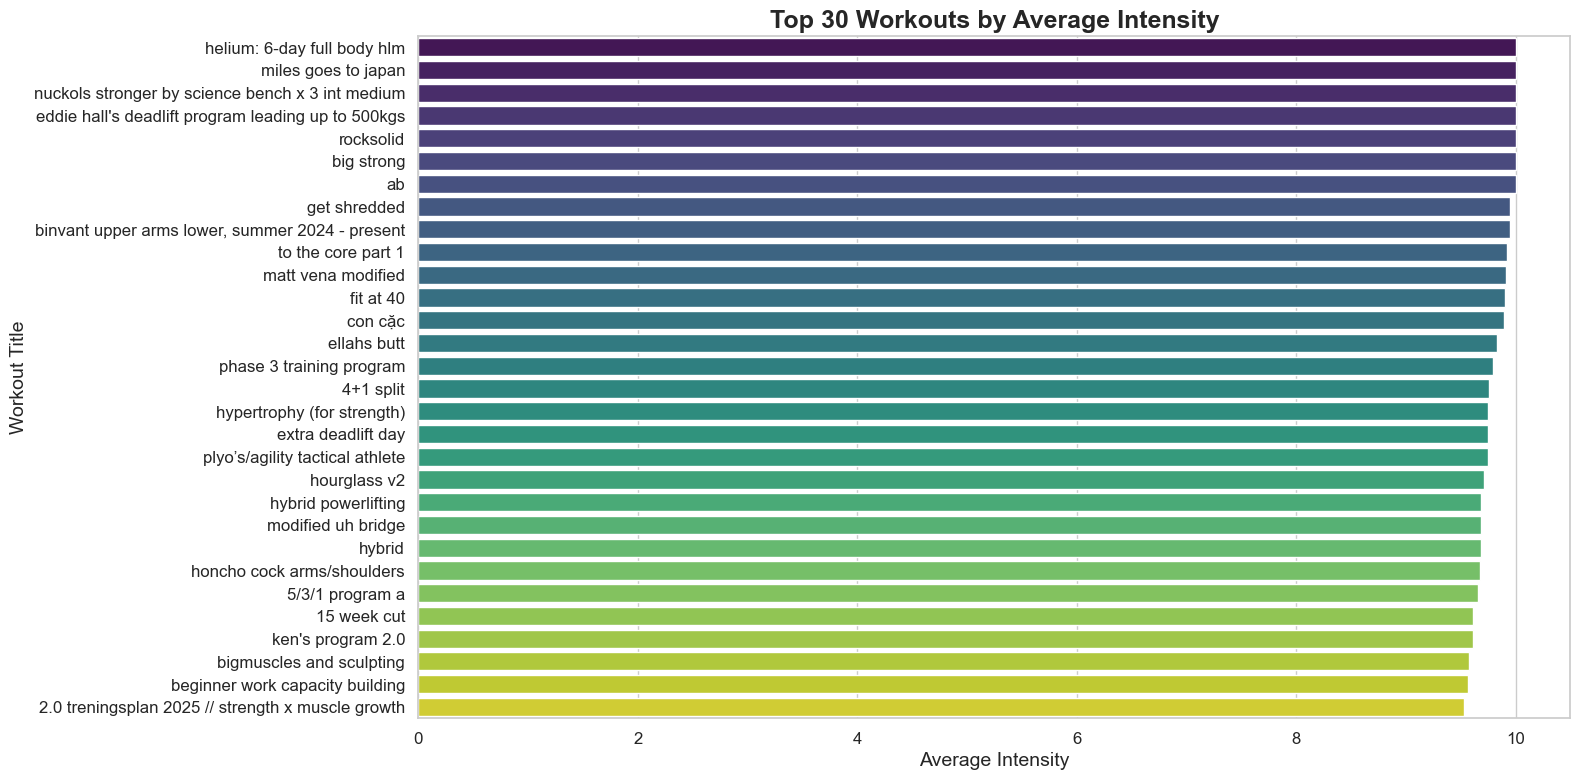

In [ ]:
# Group by title and calculate mean intensity
intensity_by_title = huge_data.groupby('title')['intensity'].mean().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid", font_scale=1.1)

# Plot only the top 30 for readability
top_n = 30
sns.barplot(
    x=intensity_by_title.head(top_n).values,
    y=intensity_by_title.head(top_n).index,
    palette="viridis"
)

plt.title('Top 30 Workouts by Average Intensity', fontsize=18, weight='bold')
plt.xlabel('Average Intensity', fontsize=14)
plt.ylabel('Workout Title', fontsize=14)
plt.tight_layout()
plt.show()


## Feature Engineering

In [2]:
# Checkpoint to skip data cleaning on fresh load
huge_data = pd.read_csv('data/cleaned_600k.csv')
huge_data.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
goal_map = {
    'Olympic Weightlifting': 'goal_olympic_weightlifting',
    'Muscle & Sculpting': 'goal_muscle_&_sculpting',
    'Bodyweight Fitness': 'goal_bodyweight_fitness',
    'Powerbuilding': 'goal_powerbuilding',
    'Bodybuilding': 'goal_bodybuilding',
    'Powerlifting': 'goal_powerlifting',
    'Athletics': 'goal_athletics'
}

level_map = {
    'Beginner': 'level_beginner',
    'Novice': 'level_novice',
    'Intermediate': 'level_intermediate',
    'Advanced': 'level_advanced'
}

def add_multilabel_onehot(df, col, value_map, prefix):
    exploded = df[[col]].explode(col)
    exploded[col] = exploded[col].apply(lambda x: f"{prefix}{x}")

    one_hot = pd.get_dummies(exploded[col])
    one_hot = one_hot.groupby(exploded.index).sum()

    expected_cols = list(value_map.values())
    for colname in expected_cols:
        if colname not in one_hot.columns:
            one_hot[colname] = 0
    one_hot = one_hot[expected_cols]

    for c in one_hot.columns:
        df[c] = one_hot[c]

In [4]:
# Clean up sets and reps columns, create new columns for the model to learn on
# Sets is average per week, reps is average per exercise

huge_data['is_rep_based'] = huge_data['reps'] > 0
huge_data['reps_count'] = huge_data['reps'].apply(lambda x: x if x > 0 else 0)
huge_data['reps_time'] = huge_data['reps'].apply(lambda x: -x if x < 0 else 0)


# Precompute program_length for each (title, description) pair to avoid repeated lookups
program_length_map = huge_data.drop_duplicates(['title', 'description']) \
    .set_index(['title', 'description'])['program_length'].to_dict()

def per_week(series, title, description):
    program_length = program_length_map.get((title, description), 0)
    return series.sum() / program_length if program_length else 0

# Group by program, aggregate features, and compute sets & reps per week

grouped = huge_data.groupby(['title', 'description'])
program_features = grouped.agg({
    'reps_count': 'mean',   # mean reps per exercise
    'reps_time': 'mean',
    'is_rep_based': 'mean'
}).reset_index()

# Compute sets per week and reps per week
program_features['sets'] = [
    per_week(group['sets'], title, description)
    for (title, description), group in grouped
]
program_features['reps_per_week'] = [
    per_week(group['reps_count'], title, description)
    for (title, description), group in grouped
]

In [5]:
# Extract categorical and numerical features from original dataset
# Aggregate to program-level to ensure one row per program
program_metadata = huge_data.groupby(['title', 'description']).agg({
    'level': 'first',
    'goal': 'first',
    'equipment': 'first',
    'program_length': 'mean',
    'time_per_workout': 'mean',
    'intensity': 'mean'
}).reset_index().reset_index().drop(columns=['index'])

# One-hot encode nested categorical features
categorical_cols = ['level', 'goal', 'equipment']
add_multilabel_onehot(program_metadata, 'level', level_map, 'level_')
add_multilabel_onehot(program_metadata, 'goal', goal_map, 'goal_')

# One hot encode normal categorical feature
ohe = OneHotEncoder(sparse_output=False)
equip_ohe = ohe.fit_transform(program_metadata[['equipment']])

feature_names = ohe.get_feature_names_out(['equipment'])
equip_df = pd.DataFrame(equip_ohe, columns=feature_names, index=program_metadata.index)

program_metadata = program_metadata.join(equip_df)

# Merge back sets and reps columns to rest of the dataset features
program_features = program_features.merge(
    program_metadata,
    on=['title', 'description'],
    how='left'
)

program_features = program_features.drop(columns=['level', 'goal', 'equipment'])
# Combining textual columns for model training
program_features['text'] = program_features['title'] + program_features['description']
program_features


,title,description,reps_count,reps_time,is_rep_based,sets,reps_per_week,program_length,time_per_workout,intensity,...,goal_bodyweight_fitness,goal_powerbuilding,goal_bodybuilding,goal_powerlifting,goal_athletics,equipment_at home,equipment_dumbbell only,equipment_full gym,equipment_garage gym,text
0,(mass monster) high intensity 4 day upper lowe...,Build tones of muscular with this high intensi...,9.994624,0.000000,1.000000,53.000000,309.833333,12.0,90.0,8.276882,...,0,0,0,0,0,0.0,0.0,1.0,0.0,(mass monster) high intensity 4 day upper lowe...
1,(not my program)shj jotaro,Build strength and size,7.906250,0.000000,1.000000,76.000000,189.750000,8.0,60.0,7.098958,...,0,0,0,0,0,0.0,0.0,1.0,0.0,(not my program)shj jotaroBuild strength and size
2,1 powerlift per day powerbuilding 5 day bro split,Based off of Andy Baker's KCS (Kingwood Streng...,10.920188,0.000000,1.000000,85.833333,387.666667,6.0,90.0,8.352113,...,0,0,0,0,0,0.0,0.0,1.0,0.0,1 powerlift per day powerbuilding 5 day bro sp...
3,10 week deadlift focus,Increase deadlift,11.988764,0.000000,1.000000,112.300000,426.800000,10.0,80.0,7.365169,...,0,0,0,0,0,0.0,0.0,1.0,0.0,10 week deadlift focusIncrease deadlift
4,10 week mass building program,This workout is designed to increase your musc...,13.792857,0.000000,1.000000,65.000000,386.200000,10.0,70.0,6.460714,...,0,0,0,0,0,0.0,0.0,0.0,1.0,10 week mass building programThis workout is d...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,🎧,Lihaskasvu,10.635965,0.000000,1.000000,66.000000,202.083333,12.0,90.0,7.890351,...,0,0,0,0,0,0.0,0.0,0.0,1.0,🎧Lihaskasvu
2628,👾reza's routine👾,This is a beginner friendly routine made for m...,11.200000,0.000000,1.000000,94.000000,560.000000,1.0,60.0,6.600000,...,0,0,0,0,0,0.0,1.0,0.0,0.0,👾reza's routine👾This is a beginner friendly ro...
2629,"🔥 ""upper body dominance: 3-day growth system"" 🔥","""Upper Body Dominance: A science-based 3-day w...",8.906250,0.625000,0.937500,32.000000,142.500000,6.0,60.0,6.750000,...,0,0,0,0,0,0.0,0.0,1.0,0.0,"🔥 ""upper body dominance: 3-day growth system"" ..."
2630,🙈🙉🙊🐵,Muscle Memory Training,10.640777,0.058252,0.995146,72.500000,274.000000,8.0,90.0,8.092233,...,0,0,0,0,0,0.0,0.0,1.0,0.0,🙈🙉🙊🐵Muscle Memory Training


In [6]:
program_features.describe()

,reps_count,reps_time,is_rep_based,sets,reps_per_week,program_length,time_per_workout,intensity,level_beginner,level_novice,...,goal_muscle_&_sculpting,goal_bodyweight_fitness,goal_powerbuilding,goal_bodybuilding,goal_powerlifting,goal_athletics,equipment_at home,equipment_dumbbell only,equipment_full gym,equipment_garage gym
count,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.000000,2632.0,2632.0,...,2632.0,2632.0,2632.0,2632.0,2632.0,2632.0,2632.000000,2632.000000,2632.000000,2632.000000
mean,10.378716,1.046870,0.985826,63.996121,252.533132,8.824468,68.952128,7.868160,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045593,0.026596,0.712386,0.215426
std,2.136301,11.767190,0.033964,33.601289,128.853524,4.179955,24.324504,0.734808,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.208640,0.160929,0.452736,0.411195
min,3.639706,0.000000,0.375000,1.000000,7.800000,1.000000,10.000000,3.928030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,9.082108,0.000000,0.997293,40.500000,165.500000,5.000000,60.000000,7.448607,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,10.301503,0.000000,1.000000,59.464286,237.708333,8.000000,60.000000,7.925000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000
75%,11.512931,0.023886,1.000000,82.000000,316.677083,12.000000,90.000000,8.315242,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000
max,30.000000,450.500000,1.000000,336.000000,1678.437500,18.000000,180.000000,10.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


In [7]:
texts = program_features['text'].to_list()
BATCH_SIZE = 64
embeddings = []

# The device can be changed to 'cuda' or 'cpu' for windows computers or Colab notebooks
model = SentenceTransformer('all-MiniLM-L6-V2', device='mps')

for i in range(0, len(texts), BATCH_SIZE):
    batch = texts[i: i + BATCH_SIZE]
    embedding = model.encode(batch)
    embeddings.append(embedding)

embeddings = np.vstack(embeddings)

# Add embeddings back to features dataframe
embd_cols = [f'embd_{i}' for i in range(embeddings.shape[1])]
embd_df = pd.DataFrame(embeddings, columns=embd_cols, index=program_features.index)
program_features = pd.concat([program_features, embd_df], axis=1)


In [8]:
md_cols = [
    'reps_count', 'reps_time', 'is_rep_based',
    'sets', 'reps_per_week', 'program_length', 'time_per_workout',
    'intensity', 'level_beginner', 'level_novice', 'level_intermediate',
    'level_advanced', 'goal_olympic_weightlifting',
    'goal_muscle_&_sculpting', 'goal_bodyweight_fitness',
    'goal_powerbuilding', 'goal_bodybuilding', 'goal_powerlifting',
    'goal_athletics', 'equipment_at home', 'equipment_dumbbell only',
    'equipment_full gym', 'equipment_garage gym'
]

final_features = program_features[md_cols + embd_cols]

## Model Training

In [9]:
scaler = StandardScaler()
final_features_scaled = pd.DataFrame(
    scaler.fit_transform(final_features),
    columns=final_features.columns,
    index=final_features.index
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


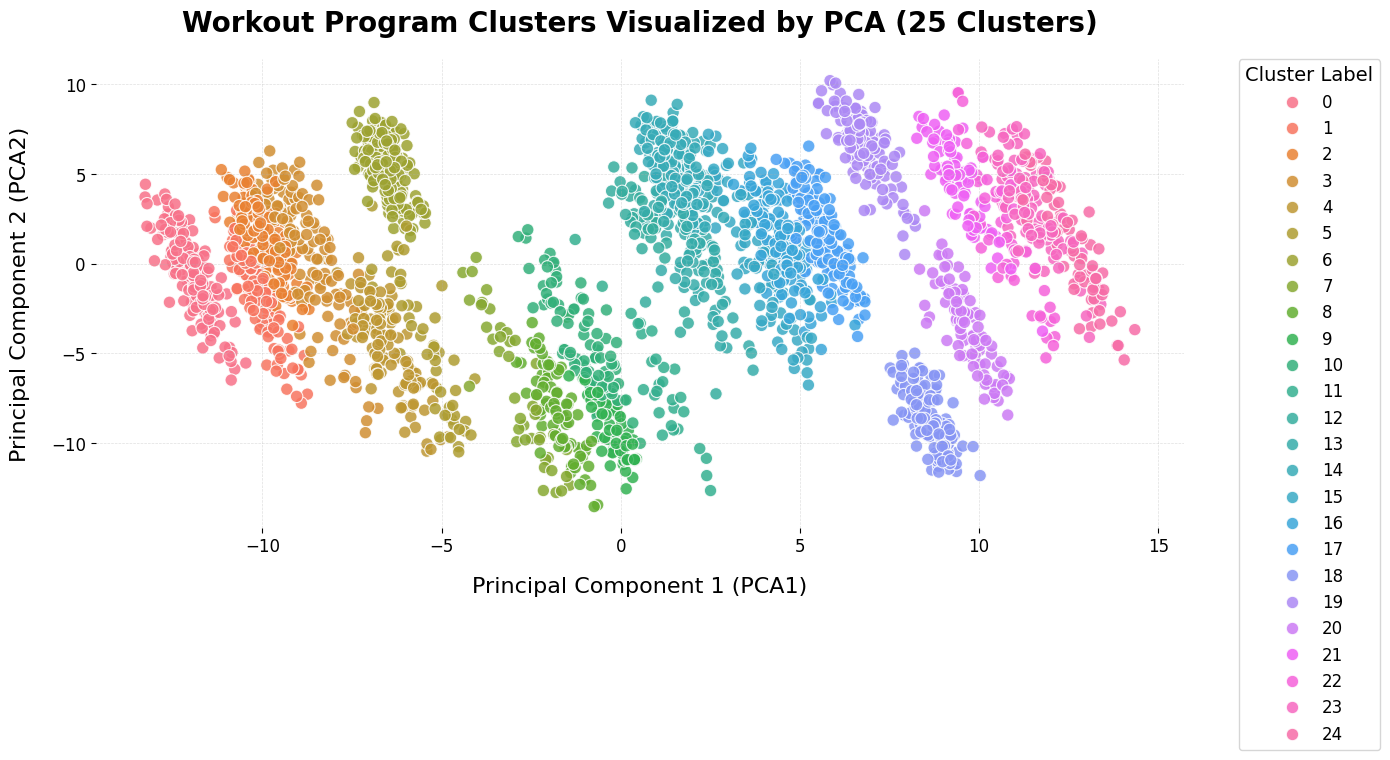

In [10]:
kmeans = KMeans(n_clusters=25, random_state=4)

clustering_data = final_features_scaled.copy()
clustering_data['cluster'] = kmeans.fit_predict(clustering_data)

pca = PCA(n_components=2, random_state=4)
reduced = pca.fit_transform(clustering_data)
clustering_data['pca1'], clustering_data['pca2'] = reduced[:, 0], reduced[:,1]

plt.figure(figsize=(14, 7))
palette = sns.color_palette("husl", n_colors=clustering_data['cluster'].nunique())

scatter = sns.scatterplot(
    data=clustering_data,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette=palette,
    s=80,
    edgecolor='w',
    alpha=0.85,
    linewidth=0.8,
    legend='full'
)

plt.title('Workout Program Clusters Visualized by PCA (25 Clusters)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Principal Component 1 (PCA1)', fontsize=16, labelpad=15)
plt.ylabel('Principal Component 2 (PCA2)', fontsize=16, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Cluster Label', title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()

## Model Prediction

In [11]:
similarities = cosine_similarity(clustering_data)

In [12]:
def find_top_n(similarity_matrix, n_programs, program, metadata, info, cluster=None, features=None):
    """
    Gets the top n workout programs.

    Args:
        similarity_matrix (np.ndarray): Matrix of similarity scores between programs.
        n_programs (int): Number of top similar programs to return.
        program (int): Index of the program to compare against.
        metadata (list): List of metadata column names to include in the result.
        info (list): List of info column names to include in the result.

    Returns:
        list[pd.DataFrame]: List of DataFrames, each containing the metadata and info for a top similar program.
    """
    scores = similarity_matrix[program]

    if cluster:
        mask = (features['cluster'] == cluster).values
        scores = scores * mask

    idxs = np.argsort(scores)[::-1]

    # Gets the top n indices that aren't itself
    top_n = idxs[idxs != program][:n_programs]
    top_titles = program_features['title'][top_n]

    # For each of the top n workout programs, get out only specific columns and add each DF to a list
    progs = [huge_data[huge_data['title'] == i][metadata+info] for i in top_titles]
    return progs

def program_recommender(program, features, similarity_matrix, model=model, n_programs=5, within_cluster=False):
    """
    Takes in a user's inputted program vector or existing program index 
    and computes the top n similar workout programs.

    Args:
        program (int or list): If int, the index of an existing program to use as the query.
                               If list, a vector of numeric features followed by a string description
                               representing a custom user program.
        features (np.ndarray): Feature matrix of all programs (used for custom queries).
        model (SentenceTransformer): Model used to encode text descriptions (default: global model).
        n_programs (int): Number of similar programs to return (default: 5).

    Returns:
        list[pd.DataFrame]: List of DataFrames, each containing metadata and info for a recommended program.
    """
    metadata = ['title', 'description', 'level', 'goal', 'equipment', 'program_length','time_per_workout', 'number_of_exercises']
    info = ['week', 'day', 'exercise_name', 'sets', 'reps', 'intensity']

    if (type(program) == int):
        return find_top_n(similarity_matrix, 
                          n_programs, 
                          program, 
                          metadata, 
                          info, 
                          features['cluster'].iloc[program] if within_cluster else None,
                          features if within_cluster else None
        )
    elif (type(program) == list):
        # Encodes the user's description for the workout
        query_embd = model.encode(program[-1])
        query_numeric = np.array(program[:-1], dtype=np.float32)
        # Concatenate the numeric features and the embedding
        query_full = np.concatenate([query_numeric, query_embd.flatten()])

        # Standardize the query
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features.drop(columns=['cluster']))
        query_full_scaled = (scaler.transform([query_full])[0].reshape(1, -1)) # Reshaping turns the query into a 2D array
        cluster = int(kmeans.predict(query_full_scaled))

        # Compute cosine similarity between the query and all existing (already scaled) features
        similarities_to_query = cosine_similarity(
            features_scaled,
            query_full_scaled 
        ).flatten()

        features_scaled = pd.concat([pd.DataFrame(features_scaled), features['cluster']], axis=1)

        return find_top_n(
            similarities_to_query.reshape(1, -1),
            n_programs,
            0,
            metadata,
            info,
            cluster if within_cluster else None,
            features_scaled if within_cluster else None
        )
    
    else:
        raise ValueError('Value inputted is not an int or NumPy array.')

In [13]:
"""
Numerical Columns:
    'reps_count': Mean reps per rep based exercise 
    'reps_time': Mean time per time based exercise ,
    'is_rep_based': Percentage of rep based exercises (0-1),
    'sets': Total number of sets per week,
    'reps_per_week': Total number of reps per week,
    'program_length': Program length (weeks),
    'time_per_workout': Workout length (minutes),
    'intensity': Average intensity level across the program (1-10),

OHE Columns:
    'level_beginner',
    'level_novice',
    'level_intermediate',
    'level_advanced',
    'goal_olympic_weightlifting', 
    'goal_muscle_&_sculpting',
    'goal_bodyweight_fitness', 
    'goal_powerbuilding', 
    'goal_bodybuilding', 
    'goal_powerlifting', 
    'goal_athletics', 
    'equipment_at home', 
    'equipment_dumbbell only', 
    'equipment_full gym', 
    'equipment_garage gym'

"""
query = [10, 0, 1, 100, 400, 8, 60, 10, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 'Insane Arnold program, not for the weak. You need max intensity in every exercise. Push to failure ALWAYS.']

In [14]:
final_features.loc[:, 'cluster'] = clustering_data['cluster']

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_75505/397643800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features.loc[:, 'cluster'] = clustering_data['cluster']


In [15]:
test = program_recommender(query, features=final_features, similarity_matrix=similarities, model=model, within_cluster=True)

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_75505/3275179895.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cluster = int(kmeans.predict(query_full_scaled))


In [16]:
for i in range(len(test)):
    title = test[i]['title'].iloc[0]
    description = test[i]['description'].iloc[0]
    print("="*40)
    print(f"Title: {title}\n")
    print(f"Description: {description}")
    print("="*40 + "\n")

Title: strongman

Description: Strongman
￼

Title: high frequent high intensity low volume training

Description: To Build a Foundation

Title: end of the year stronger

Description: This program will help you tone your body and maximize each work out to target all of your muscles. This is perfect if you only have 3 days a week to dedicate your work out.

Title: mike mentzer's full body routine

Description: This program is designed to build muscle through high-intensity training techniques.

The program is recommended for beginners by Mike Mentzer in his instructional video about Heavy Duty training and is designed secondarily to familiarize the beginner with the basic weightlifting movements. However, Mentzer notes that advanced trainees can benefit from this program as well.

Mentzer recommends a training strategy which is slightly unconventional. Each exercise (with few exceptions) should be taken to momentary muscular failure in all three phases of the movement: the concentric (po

While we are getting back similar-ish programs to our query, they aren't that close to the ones we want. Based on a huge dataset of user-generated data like the one we have, we would assume that our query would line up with programs that capture more of the meaning. To do this, we can fine-tune our model on our dataset. 

## Fine-tuning a Model on Lifting Corpus

In a perfect world, we would have data that is labeled with a group type and we could use similarity techniques from there. We could then use supervised fine-tuning via methods like NLI to let the model understand the domain. Unfortunately, that isn't the case. To fine-tune on unlabeled data, we will use an unsupervised fine-tuning technique known as Masked Language Modeling (MLM).

MLM basically boils down to masking (blanking out) ~15% of the tokens across out sample texts and telling the model to predict these masked words. This forces our model to learn contextual word representations in the lifting domain.

In [72]:
tokenizer = RobertaTokenizerFast.from_pretrained('FacebookAI/roberta-base')
roberta_model = RobertaForMaskedLM.from_pretrained('FacebookAI/roberta-base')

In [73]:
descriptions = program_features['description'].tolist()

# Tokenizes the descroptions to be fed into the model
inputs = tokenizer(descriptions, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
# Creates the labels we use to compare for against the masked tokens
inputs['labels'] = inputs.input_ids.detach().clone()

In [74]:
# Randomly select 15% of tokens to be masked 
# (101 is the [CLS] token, 102 is the [SEP], 103 is the [MASK] token, 0 is the [PAD] token, or padding)
# We do not want to overwrite the start, end, and padding tokens, so we cut them out
rand = torch.rand(inputs.input_ids.shape)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102) * (inputs.input_ids != 0)

# Get the randomly chosen tokens for each text and apply masking token
selection = []
for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

In [75]:
# Custom Dataset to user in Dataloader in training
class LiftingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
      self.encodings = encodings

    def __getitem__(self, idx):
      return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
      return self.encodings.input_ids.shape[0]

In [76]:
dataset = LiftingDataset(inputs)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
roberta_model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [77]:
# Optimizer used is Adam with weight decay, which reduces the chance of overfitting
# An optimizer efficiently trains the model by adjusting the learning rates for each parameter on each pass
roberta_model.train()
optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
epochs = 3

for epoch in range(epochs):
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # Initialize calculated gradients
        optim.zero_grad()
        # Get all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # Process
        outputs = roberta_model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # Extract loss
        loss = outputs.loss
        # Calculate loss for every parameter that needs grad update
        loss.backward()
        # Update parameters
        optim.step()
        # Progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

In [ ]:
roberta_model.save_pretrained('./roberta_finetuned')
tokenizer.save_pretrained('./roberta_finetuned')

## Converting Fine-tuned Model to a Sentence Transformer

In [18]:
class CustomSentenceEmbedder:
    def __init__(self, model_name="./roberta_finetuned", device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.tokenizer = AlbertTokenizerFast.from_pretrained(model_name)
        self.model = AlbertModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

    def encode(self, sentences, batch_size=32, normalize=True):
        # Allows for single or multiple sentence inputs
        if isinstance(sentences, str):
            sentences = [sentences]
        
        all_embeddings = []
        # Divides input into batches to prevent OOM errors
        for start in range(0, len(sentences), batch_size):
            batch = sentences[start:start+batch_size]

            encoded_input = self.tokenizer(batch, padding=True, truncation=True,
                                           return_tensors='pt').to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**encoded_input)
                token_embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden_dim)
                attention_mask = encoded_input['attention_mask']
                
                # Mean pooling
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
                sum_embeddings = (token_embeddings * input_mask_expanded).sum(1) # (B, H)
                sum_mask = attention_mask.sum(1).unsqueeze(-1) # (B, 1)
                embeddings = sum_embeddings / sum_mask
                
                if normalize:
                    embeddings = F.normalize(embeddings, p=2, dim=1)

                all_embeddings.append(embeddings.cpu())
        
        return torch.cat(all_embeddings, dim=0)

    def save(self, save_directory):
        """
        Save the model and tokenizer to the specified directory.
        """
        os.makedirs(save_directory, exist_ok=True)
        self.model.save_pretrained(save_directory)
        self.tokenizer.save_pretrained(save_directory)

    @classmethod
    def load(cls, load_directory, device=None):
        """
        Load the model and tokenizer from the specified directory.
        """
        return cls(model_name=load_directory, device=device)

embedder = CustomSentenceEmbedder(device='mps', model_name='./albert_finetuned')

# Later, or in a different program, reload the embedder:
# embedder_loaded = RobertaSentenceEmbedder.load('./roberta_custom_st', device='cpu')


Some weights of AlbertModel were not initialized from the model checkpoint at ./albert_finetuned and are newly initialized: ['pooler.bias', 'pooler.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
texts = program_features['text'].to_list()
BATCH_SIZE = 64
embeddings_test = embedder.encode(texts, batch_size=BATCH_SIZE).numpy()

# Add embeddings back to features dataframe
embd_cols = [f'embd_{i}' for i in range(embeddings_test.shape[1])]
embd_df = pd.DataFrame(embeddings_test, columns=embd_cols, index=program_features.index)
program_features_test = program_features.copy().drop(columns=[col for col in program_features.columns if col.startswith('embd_')])
program_features_test = pd.concat([program_features_test, embd_df], axis=1)


In [20]:
final_features_test = program_features_test[md_cols + embd_cols]

In [20]:
# Scale for KMeans and PCA
final_features_test_scaled = pd.DataFrame(
    scaler.fit_transform(final_features_test),
    columns=final_features_test.columns,
    index=final_features_test.index
)

## Model Prediction

In [21]:
# Set up KMeans model to cluster the workout programs together
clustering_data_test = final_features_test_scaled.copy()
kmeans = KMeans(n_clusters=25, random_state=4)
clustering_data_test['cluster'] = kmeans.fit_predict(clustering_data_test)

In [22]:
# Add cluster back to unscaled dataset as the function needs unscaled data
final_features_test.loc[:, 'cluster'] = clustering_data_test['cluster']

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_67789/48959608.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_test.loc[:, 'cluster'] = clustering_data_test['cluster']


In [23]:
similarities_test = cosine_similarity(clustering_data_test)

In [33]:
new = program_recommender(query, final_features_test, similarity_matrix=similarities_test, model=embedder, within_cluster=True)

/var/folders/cj/mk6_35t16dg3wd3vjv0ymvw00000gn/T/ipykernel_67789/3275179895.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cluster = int(kmeans.predict(query_full_scaled))


In [34]:
for i in range(len(new)):
    title = new[i]['title'].iloc[0]
    description = new[i]['description'].iloc[0]
    print("="*40)
    print(f"Title: {title}\n")
    print(f"Description: {description}")
    print("="*40 + "\n")

Title: building the titan

Description: Get jacked - pure hypertrophy. You need to aim to up as many reps or weight every session. This is about pushing yourself to the limit.

Title: god’s warrior

Description: Rapidly paced, purposeful hypertrophy program. Get big, get strong, get moving, get out of your beginner gains.

Title: primal readiness - primer | overcome thyself

Description: This program is built for warfighters-past, present, and future. Whether you're prepping for selection, getting back to fighting shape, or refusing to let the standard slip, this hybrid system delivers. 

Shred fat with intensity, dominate functional circuits designed for combat readiness, and lift heavy to forge battlefield strength. Every session pushes your limits. No fluff. No excuses. Just discipline, grit, and results.

You don’t rise to the occasion, you fall to the level of your training. So train like your life depends on it.

Train for the battle. Conquer the mission. Forge the warrior within

The overall quality of outputs has drastically increased! The fine-tuned model has successfully improved on finding similar workouts to the user's query.

With the pretrained model, the "fitness" terminology wasn't captured and understood. On the other hand, the fine-tuned model actually picks up on unique lingo. For example, it picks up how Arnold is not just a person's name (Arnold Schwarzenegger) but a unique training split named after him. It also picks up specifically how we are looking for a intense workout regime that isn't a whole lot of fluff. It's meant for people who want to be serious about lifting.

## Final Notes:
* Instead of the current method of training a regular RoBERTa model on the lifting corpus and then wrapping it to work like a sentence transformer, we could have used Text-Search Data Augmentation for Embeddings (TSDAE) to train the sentence embeddings directly. Theoretically, this would have better performance in encoding the semantic similarity.
    * The reason that method wasn't done here was because I already fine-tuned a token-level roBERTa model on this data, and it still worked much better than the base sentence-transfomers `all-miniLM-L6-V2` model.
    * I also wanted to gain more experience working with PyTorch, and the method used allowed me to get my hands dirty.

* A limitation with this model is that it won't be able to reliably find programs that have a very low intensity rating, as those types of programs rarely show up in the dataset. 
    * The data was sourced from user generated programs from [Boostcamp](https://www.boostcamp.app/), a workout tracking app. People that download this app are much more likely to be passionate about fitness, and low intensity workouts (generally) don't result in as much gains as medium to high intensity workouts. The subset of people with this app will be the ones who strive for higher gains. 
    * Low intensity workouts are great for people just getting into fitness or people who just want to be a little healthier. 
    * Some future steps to improve this recommendation system would be to source more of this low intensity workouts across a variety of use cases to increase its generalizability.

* The fine-tuned roBERTa model is too large to run on free-tier cloud services (GCP, Streamlit Community Cloud), so just for cloud deployment I trained a smaller ALBERT model as well. It won't provide the best possible recommendations, but it should still be extremely serviceable.

* If you'd like to get the best possible recommendations, clone this repo and run the Streamlit app locally.

## Credits
Dataset from Adnane Louardi: [Link](https://www.kaggle.com/datasets/adnanelouardi/600k-fitness-exercise-and-workout-program-dataset/code)